In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.10.2
True


In [2]:
import sys
sys.path.append("mmf")
sys.path.append('vqa-maskrcnn-benchmark')

In [3]:
import yaml
import cv2
import torch
import requests
import numpy as np
import gc
import torch.nn.functional as F
import pandas as pd


import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
from IPython.display import display, HTML, clear_output
from ipywidgets import widgets, Layout
from io import BytesIO
from argparse import Namespace


In [4]:
from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.layers import nms
from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.utils.model_serialization import load_state_dict


from mmf.datasets.processors.processors import VocabProcessor, VQAAnswerProcessor
from mmf.models.pythia import Pythia
from mmf.common.registry import registry
from mmf.common.sample import Sample, SampleList
from mmf.utils.env import setup_imports
from mmf.utils.configuration import Configuration


In [5]:
setup_imports()

In [8]:
class MMFDemo:
    TARGET_IMAGE_SIZE = [448, 448]
    CHANNEL_MEAN = [0.485, 0.456, 0.406]
    CHANNEL_STD = [0.229, 0.224, 0.225]

    def __init__(self):
        self._init_processors()
        self.pythia_model = self._build_pythia_model()
        self.detection_model = self._build_detection_model()
        self.resnet_model = self._build_resnet_model()

    def _init_processors(self):
        args = Namespace()
        args.opts = [
            "config=projects/pythia/configs/vqa2/defaults.yaml",
            "datasets=vqa2",
            "model=pythia",
            "evaluation.predict=True",
        ]
        args.config_override = None

        configuration = Configuration(args=args)

        config = self.config = configuration.config
        vqa_config = config.dataset_config.vqa2
        text_processor_config = vqa_config.processors.text_processor
        answer_processor_config = vqa_config.processors.answer_processor

        text_processor_config.params.vocab.vocab_file = (
            "./content/model_data/vocabulary_100k.txt"
        )
        answer_processor_config.params.vocab_file = (
            "./content/model_data/answers_vqa.txt"
        )
        # Add preprocessor as that will needed when we are getting questions from user
        self.text_processor = VocabProcessor(text_processor_config.params)
        self.answer_processor = VQAAnswerProcessor(answer_processor_config.params)

        registry.register("vqa2_text_processor", self.text_processor)
        registry.register("vqa2_answer_processor", self.answer_processor)
        registry.register(
            "vqa2_num_final_outputs", self.answer_processor.get_vocab_size()
        )

    def _build_pythia_model(self):
        state_dict = torch.load("./content/model_data/pythia.pth")
        model_config = self.config.model_config.pythia
        model_config.model_data_dir = "/content/"
        model = Pythia(model_config)
        model.build()
        model.init_losses()

        if list(state_dict.keys())[0].startswith("module") and not hasattr(
            model, "module"
        ):
            state_dict = self._multi_gpu_state_to_single(state_dict)

        model.load_state_dict(state_dict, strict=False)
        model.to("cuda")
        model.eval()

        return model

    def _build_resnet_model(self):
        self.data_transforms = transforms.Compose(
            [
                transforms.Resize(self.TARGET_IMAGE_SIZE),
                transforms.ToTensor(),
                transforms.Normalize(self.CHANNEL_MEAN, self.CHANNEL_STD),
            ]
        )
        resnet152 = models.resnet152(pretrained=True)
        resnet152.eval()
        modules = list(resnet152.children())[:-2]
        self.resnet152_model = torch.nn.Sequential(*modules)
        self.resnet152_model.to("cuda")

    def _multi_gpu_state_to_single(self, state_dict):
        new_sd = {}
        for k, v in state_dict.items():
            if not k.startswith("module."):
                raise TypeError("Not a multiple GPU state of dict")
            k1 = k[7:]
            new_sd[k1] = v
        return new_sd

    def predict(self, url, question):
        with torch.no_grad():
            detectron_features = self.get_detectron_features(url)
            resnet_features = self.get_resnet_features(url)

            sample = Sample()

            processed_text = self.text_processor({"text": question})
            sample.text = processed_text["text"]
            sample.text_len = len(processed_text["tokens"])

            sample.image_feature_0 = detectron_features
            sample.image_info_0 = Sample(
                {"max_features": torch.tensor(100, dtype=torch.long)}
            )

            sample.image_feature_1 = resnet_features

            sample_list = SampleList([sample])
            sample_list = sample_list.to("cuda")

            scores = self.pythia_model(sample_list)["scores"]
            scores = torch.nn.functional.softmax(scores, dim=1)
            actual, indices = scores.topk(5, dim=1)

            top_indices = indices[0]
            top_scores = actual[0]

            probs = []
            answers = []

            for idx, score in enumerate(top_scores):
                probs.append(score.item())
                answers.append(self.answer_processor.idx2word(top_indices[idx].item()))

        gc.collect()
        torch.cuda.empty_cache()

        return probs, answers

    def _build_detection_model(self):

        cfg.merge_from_file("./content/model_data/detectron_model.yaml")
        cfg.freeze()

        model = build_detection_model(cfg)
        checkpoint = torch.load(
            "./content/model_data/detectron_model.pth", map_location=torch.device("cpu")
        )

        load_state_dict(model, checkpoint.pop("model"))

        model.to("cuda")
        model.eval()
        return model

    def get_actual_image(self, image_path):
        if image_path.startswith("http"):
            path = requests.get(image_path, stream=True).raw
        else:
            path = image_path

        return path

    def _image_transform(self, image_path):
        path = self.get_actual_image(image_path)

        img = Image.open(path)
        im = np.array(img).astype(np.float32)
        im = im[:, :, ::-1]
        im -= np.array([102.9801, 115.9465, 122.7717])
        im_shape = im.shape
        im_size_min = np.min(im_shape[0:2])
        im_size_max = np.max(im_shape[0:2])
        im_scale = float(800) / float(im_size_min)
        # Prevent the biggest axis from being more than max_size
        if np.round(im_scale * im_size_max) > 1333:
            im_scale = float(1333) / float(im_size_max)
        im = cv2.resize(
            im, None, None, fx=im_scale, fy=im_scale, interpolation=cv2.INTER_LINEAR
        )
        img = torch.from_numpy(im).permute(2, 0, 1)
        return img, im_scale

    def _process_feature_extraction(
        self, output, im_scales, feat_name="fc6", conf_thresh=0.2
    ):
        batch_size = len(output[0]["proposals"])
        n_boxes_per_image = [len(_) for _ in output[0]["proposals"]]
        score_list = output[0]["scores"].split(n_boxes_per_image)
        score_list = [torch.nn.functional.softmax(x, -1) for x in score_list]
        feats = output[0][feat_name].split(n_boxes_per_image)
        cur_device = score_list[0].device

        feat_list = []

        for i in range(batch_size):
            dets = output[0]["proposals"][i].bbox / im_scales[i]
            scores = score_list[i]

            max_conf = torch.zeros((scores.shape[0])).to(cur_device)

            for cls_ind in range(1, scores.shape[1]):
                cls_scores = scores[:, cls_ind]
                keep = nms(dets, cls_scores, 0.5)
                max_conf[keep] = torch.where(
                    cls_scores[keep] > max_conf[keep], cls_scores[keep], max_conf[keep]
                )

            keep_boxes = torch.argsort(max_conf, descending=True)[:100]
            feat_list.append(feats[i][keep_boxes])
        return feat_list

    def masked_unk_softmax(self, x, dim, mask_idx):
        x1 = F.softmax(x, dim=dim)
        x1[:, mask_idx] = 0
        x1_sum = torch.sum(x1, dim=1, keepdim=True)
        y = x1 / x1_sum
        return y

    def get_resnet_features(self, image_path):
        path = self.get_actual_image(image_path)
        img = Image.open(path).convert("RGB")
        img_transform = self.data_transforms(img)

        if img_transform.shape[0] == 1:
            img_transform = img_transform.expand(3, -1, -1)
        img_transform = img_transform.unsqueeze(0).to("cuda")

        features = self.resnet152_model(img_transform).permute(0, 2, 3, 1)
        features = features.view(196, 2048)
        return features

    def get_detectron_features(self, image_path):
        im, im_scale = self._image_transform(image_path)
        img_tensor, im_scales = [im], [im_scale]
        current_img_list = to_image_list(img_tensor, size_divisible=32)
        current_img_list = current_img_list.to("cuda")
        with torch.no_grad():
            output = self.detection_model(current_img_list)
        feat_list = self._process_feature_extraction(output, im_scales, "fc6", 0.2)
        return feat_list[0]


In [9]:
demo = MMFDemo()

/home/yizhou/.cache/torch/mmf/glove.6B.zip: 862MB [08:42, 1.65MB/s]                                   
100%|█████████████████████████████████████████████████████▉| 399999/400000 [00:23<00:00, 17338.67it/s]

[ Downloading: https://dl.fbaipublicfiles.com/mmf/data/models/detectron/vmb_weights.tar.gz to /home/yizhou/.cache/torch/mmf/data/models/detectron.vmb_weights/vmb_weights.tar.gz ]


[ Starting checksum for vmb_weights.tar.gz]
[ Checksum successful for vmb_weights.tar.gz]
Unpacking vmb_weights.tar.gz


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /home/yizhou/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


In [11]:
def init_widgets(url, question):
    image_text = widgets.Text(description="Image URL", layout=Layout(minwidth="70%"))
    question_text = widgets.Text(description="Question", layout=Layout(minwidth="70%"))

    image_text.value = url
    question_text.value = question
    submit_button = widgets.Button(description="Ask MMF!")

    display(image_text)
    display(question_text)
    display(submit_button)

    submit_button.on_click(lambda b: on_button_click(b, image_text, question_text))

    return image_text, question_text


def on_button_click(b, image_text, question_text):
    clear_output()
    image_path = demo.get_actual_image(image_text.value)
    image = Image.open(image_path)

    scores, predictions = demo.predict(image_text.value, question_text.value)
    scores = [score * 100 for score in scores]
    df = pd.DataFrame({"Prediction": predictions, "Confidence": scores})

    init_widgets(image_text.value, question_text.value)
    display(image)

    display(HTML(df.to_html()))

In [32]:
img_url = "http://images.cocodataset.org/train2017/000000505539.jpg"
img_url = "http://images.cocodataset.org/train2017/000000505542.jpg"


In [33]:
question = "where is this place?"
#question2 = "Is it indoor or outdoor?"

In [34]:
image_path = demo.get_actual_image(img_url)

In [35]:
image = Image.open(image_path)

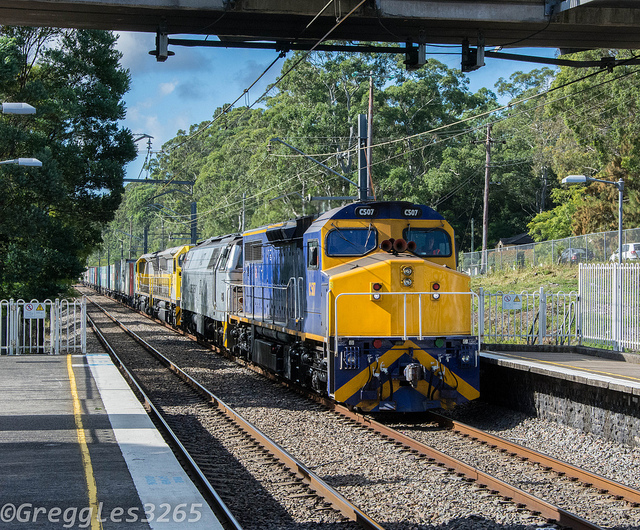

In [36]:
image

In [40]:
scores, predictions = demo.predict(img_url, question)

In [41]:
scores = [score * 100 for score in scores]
df = pd.DataFrame({"Prediction": predictions, "Confidence": scores})

In [42]:
df

,Prediction,Confidence
0,train station,94.375652
1,train tracks,4.657850
2,outside,0.265228
3,tracks,0.145302
4,station,0.143587
